In [1]:
%pylab inline

import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import datetime as dt
import dateutil.parser
import matplotlib.mlab as ml
from mpl_toolkits.axes_grid1 import make_axes_locatable

Populating the interactive namespace from numpy and matplotlib


In [2]:
def convert_pace(time):
    pace = dt.datetime.strptime(time,'%M:%S')
    pace = pace.minute + pace.second / 60.
    return pace

In [3]:
def convert(date):
    dt = dateutil.parser.parse(date).replace(tzinfo=None)
    epoch = dt.utcfromtimestamp(0)
    delta = dt - epoch
    return delta.total_seconds()

In [4]:
def speed_to_pace(speed):
    return 100 / (6 * speed)

In [5]:
path = "/Users/aRa/OneDrive/Documentos/ERASMUS/PFC/SmartCoach"
os.chdir(path)
file = 'APEruns_Strava_GAP_pace.xlsx'
Strava = pd.read_excel(file, converters={0: convert_pace, 1: convert_pace})
Strava['Slope'] = Strava.Elev / 1000.
Strava['Ratio'] = Strava.GAP / Strava.Pace
Strava.head()

,Pace,GAP,Elev,HR,Slope,Ratio
0,5.133333,4.950000,8,149,0.008,0.964286
1,4.916667,5.250000,-17,153,-0.017,1.067797
2,5.066667,4.950000,1,155,0.001,0.976974
3,5.183333,5.016667,8,158,0.008,0.967846
4,5.233333,5.150000,2,160,0.002,0.984076


In [6]:
p = 2.09 * (1 + 8.6*Strava.Elev/1000.)**0.14

In [7]:
path = "/Users/aRa/OneDrive/Documentos/ERASMUS/PFC/SmartCoach/Running_w_HR/APE_runs_oct26-mar22"
colnames = np.array(['time', 'elevation', 'distance', 'speed', 'HR'])
Datasets_all = []
os.chdir(path)
for file in glob.glob("*.tab"):
    ds = np.genfromtxt(file, skip_header=1, delimiter='\t', converters={0: convert})
    ds[:,0] -= ds[0,0]                              # time reference set to 0
      
    if (ds[:,2].max() > 10000) == (ds[:,2].max() < 13000):
        ds = pd.DataFrame(ds,columns=colnames)
        slope = np.array([])

        for i in ds.index:
            index = np.arange(i - 3 + 1, i + 3 + 1)
            index = index[(index >= 0) & (index < len(ds))]
            dataset_part = ds[['distance','elevation']].iloc[index].dropna()

            regr = lm.LinearRegression()
            regr.fit(dataset_part.distance[:,np.newaxis], np.array(dataset_part.elevation))

            slope = np.append(slope, regr.coef_)

        dataset_new = ds.drop(['elevation','HR'], axis=1)
        dataset_new['slope'] = slope

        Datasets_all.append(dataset_new)
len(Datasets_all)

7

0.950683990146


(array([-0.03793136]), 0.98299139219026921)

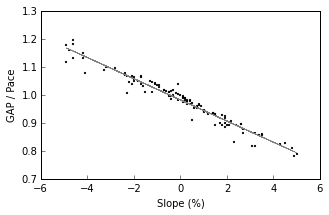

In [8]:
lr = lm.LinearRegression()
lr.fit(Strava.Slope[:, np.newaxis]*100, Strava.Ratio)
y_lr = lr.predict(Strava.Slope[:, np.newaxis]*100)

print lr.score(Strava.Slope[:, np.newaxis]*100, Strava.Ratio)

fig = plt.figure(figsize=(5,3), dpi=72)
ax = fig.add_subplot(111)
ax.scatter(Strava.Slope*100, Strava.Ratio, marker='.', c='k' , linewidths=0)
ax.plot(Strava.Slope*100, y_lr,'grey', linewidth=0.5 )
ax.set_xlim([-6, 6])
ax.set_ylim([0.7, 1.3])
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_ylabel('GAP / Pace')
ax.set_xlabel('Slope (%)')
#fig.savefig('../../../Thesis/images/linearRegressionFitStrava.pdf',bbox_inches='tight', dpi=fig.dpi)

lr.coef_, lr.intercept_

In [16]:
Strava.Slope[:,np.newaxis]

array([[ 0.008],
       [-0.017],
       [ 0.001],
       [ 0.008],
       [ 0.002],
       [-0.011],
       [ 0.001],
       [ 0.003],
       [-0.005],
       [-0.004],
       [ 0.004],
       [ 0.004],
       [-0.004],
       [-0.005],
       [ 0.003],
       [ 0.001],
       [ 0.001],
       [ 0.002],
       [-0.001],
       [ 0.002],
       [-0.009],
       [-0.001],
       [ 0.035],
       [ 0.018],
       [ 0.019],
       [ 0.027],
       [-0.017],
       [ 0.004],
       [ 0.003],
       [-0.022],
       [-0.046],
       [-0.02 ],
       [ 0.024],
       [ 0.018],
       [ 0.019],
       [ 0.014],
       [ 0.048],
       [-0.049],
       [-0.013],
       [-0.02 ],
       [-0.015],
       [-0.024],
       [ 0.01 ],
       [ 0.023],
       [-0.033],
       [-0.003],
       [ 0.007],
       [ 0.032],
       [-0.032],
       [-0.002],
       [ 0.003],
       [ 0.049],
       [-0.049],
       [-0.007],
       [ 0.01 ],
       [ 0.031],
       [-0.042],
       [ 0.   ],
       [ 0.006

In [18]:
datasets = pd.concat(Datasets_all,ignore_index=True)
datasets.sort(columns='distance', inplace=True)
datasets.index = np.arange(len(datasets))

In [19]:
colnames = np.array(['time', 'elevation', 'distance', 'speed', 'HR'])
path = "/Users/aRa/OneDrive/Documentos/ERASMUS/PFC/SmartCoach/Running_w_HR/TEST"
window_size_half = 3
os.chdir(path)
file = "test_activity.tab"

dataset = np.genfromtxt(file, skip_header=1,delimiter='\t', converters={0: convert})
dataset[:,0] -= dataset[0,0]
dataset = pd.DataFrame(dataset,columns=colnames)
slope = np.array([])

for i in dataset.index:
    index = np.arange(i-window_size_half+1, i+window_size_half+1)
    index = index[(index >= 0) & (index < len(dataset))]
    dataset_part = dataset.iloc[index].dropna()
    regr = lm.LinearRegression()
    regr.fit(dataset_part.distance[:,np.newaxis], np.array(dataset_part.elevation))
    slope = np.append(slope,regr.coef_)

validation_data = dataset.dropna()
validation_data['slope'] = slope
validation_data['pace'] = speed_to_pace(validation_data.speed)
validation_data['ratio'] = lr.coef_*slope + lr.intercept_ 
validation_data.head()

,time,elevation,distance,speed,HR,slope,pace,ratio
0,0,716.400024,1.520000,0.000,98,-0.006520,inf,0.983239
1,1,716.400024,2.370000,1.549,99,0.058397,10.759630,0.980776
2,3,716.000000,7.170000,1.577,103,0.093824,10.568590,0.979433
3,5,716.400024,12.560000,2.463,106,0.107119,6.766815,0.978928
4,8,717.599976,21.040001,2.734,109,0.111021,6.096074,0.978780


In [21]:
distances = np.array(validation_data.distance)
distance_diffs = np.concatenate([[distances[0]], distances[1:] - distances[:len(distances)-1]])

time_runner = np.array(validation_data.time)
speed_corrected = datasets.speed.median() / validation_data.ratio
time_diffs = np.concatenate([[time_runner[0]], time_runner[1:] - time_runner[:len(time_runner)-1]])
times_prediction = distance_diffs / speed_corrected
times_prediction[0] = 0
times = np.arange(len(time_runner))
rt = np.vectorize(lambda x: times_prediction[x:].sum(axis=0))
t = np.vectorize(lambda x: times_prediction[:x+1].sum(axis=0))
times_estimated_total = np.concatenate([[0], time_runner[:-1]]) + times_prediction
remaining_time = rt(times)
total_time = time_runner + remaining_time
total_predicted = t(times)

print "{0} {1:.2f} km".format(file[:-4], validation_data.distance.iloc[-1]/1000)
print "Tiempo real de carrera {}".format(dt.timedelta(seconds=validation_data.time.iloc[-1]))
print "Tiempo predicho de carrera {} ".format(dt.timedelta(seconds=round(times_prediction.sum()))),
print 'Error: {0} ({1:0.2f}%)'.format(dt.timedelta(seconds=round(abs(validation_data.time.iloc[-1] - times_prediction.sum()))),
                                   abs((validation_data.time.iloc[-1] - times_prediction.sum())/validation_data.time.iloc[-1] * 100))

test_activity 11.41 km
Tiempo real de carrera 1:00:01
Tiempo predicho de carrera 0:58:56  Error: 0:01:05 (1.80%)


In [22]:
if file == 'test_activity.tab':
    test = pd.DataFrame({'Distance': distances,
                              '$\Delta{}d$': distance_diffs,
                              'Elevation': validation_data.elevation,
                              'Speed': validation_data.speed,
                              'Speed corrected': validation_data.speed / validation_data.ratio,
                              'Slope (%)': validation_data.slope * 100,
                              'Time Runner': time_runner,
                              '$\Delta{}t^{est}$': times_prediction,
                              '$\Delta{}t^{real}$': time_diffs,
                              'Remaining Time': remaining_time,
                              'Total time': total_time,
                              'Total predicted': total_predicted,
                              'Time estimated': times_estimated_total})
    test.to_pickle('cs3_test')
    print file
    print test.head()

elif file == 'feeling_bad_activity.tab':
    feelingBad = pd.DataFrame({'Distance': distances,
                              '$\Delta{}d$': distance_diffs,
                              'Elevation': validation_data.elevation,
                              'Speed': validation_data.speed,
                              'Speed corrected': validation_data.speed / validation_data.ratio, 
                              'Slope (%)': validation_data.slope * 100,
                              'Time Runner': time_runner,
                              '$\Delta{}t^{est}$': times_prediction,
                              '$\Delta{}t^{real}$': time_diffs,
                              'Remaining Time': remaining_time,
                              'Total time': total_time,
                              'Total predicted': total_predicted,
                              'Time estimated': times_estimated_total})
    feelingBad.to_pickle('cs3_feelingBad')
    print file
    print feelingBad.head()

elif file == 'Morat_Fribourg2014.tab':
    moratFribourg = pd.DataFrame({'Distance': distances,
                              '$\Delta{}d$': distance_diffs,
                              'Elevation': validation_data.elevation,
                              'Speed': validation_data.speed,
                              'Speed corrected': validation_data.speed / validation_data.ratio,
                              'Slope (%)': validation_data.slope * 100,
                              'Time Runner': time_runner,
                              '$\Delta{}t^{est}$': times_prediction,
                              '$\Delta{}t^{real}$': time_diffs,
                              'Remaining Time': remaining_time,
                              'Total time': total_time,
                              'Total predicted': total_predicted,
                              'Time estimated': times_estimated_total})
    moratFribourg.to_pickle('cs3_morFrib')
    print file
    print moratFribourg.head()

test_activity.tab
   $\Delta{}d$  $\Delta{}t^{est}$  $\Delta{}t^{real}$   Distance   Elevation  \
0         1.52           0.000000                   0   1.520000  716.400024   
1         0.85           0.262818                   1   2.370000  716.400024   
2         4.80           1.482117                   2   7.170000  716.000000   
3         5.39           1.663437                   2  12.560000  716.400024   
4         8.48           2.616664                   3  21.040001  717.599976   

   Remaining Time  Slope (%)  Speed  Speed corrected  Time Runner  \
0     3536.025490  -0.651986  0.000         0.000000            0   
1     3536.025490   5.839672  1.549         1.579361            1   
2     3535.762672   9.382434  1.577         1.610116            3   
3     3534.280554  10.711868  2.463         2.516017            5   
4     3532.617117  11.102114  2.734         2.793273            8   

   Time estimated  Total predicted   Total time  
0        0.000000         0.000000  

In [2]:
path = "/Users/aRa/OneDrive/Documentos/ERASMUS/PFC/SmartCoach/Running_w_HR/TEST/"
os.chdir(path)

test = pd.read_pickle('cs3_test')
feelingBad = pd.read_pickle('cs3_feelingBad')
moratFribourg = pd.read_pickle('cs3_morFrib')

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid

def add_inner_title(ax, title, loc, size=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    from matplotlib.patheffects import withStroke
    if size is None:
        size = dict(size=plt.rcParams['legend.fontsize'])
    at = AnchoredText(title, loc=loc, prop=size,
                      pad=0., borderpad=0.5,
                      frameon=False, **kwargs)
    ax.add_artist(at)
    at.txt._text.set_path_effects([withStroke(foreground="w", linewidth=3)])
    return at

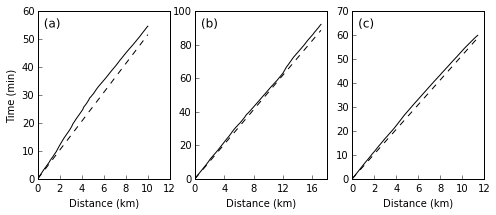

In [4]:
# REAL TIME VS PREDICTED TIME
fig = plt.figure(figsize=(8,3), dpi=72)
ax1 = fig.add_subplot(111)
divider = make_axes_locatable(ax1)
ax2 = divider.new_horizontal(size="100%", pad=0.35)
ax3 = divider.new_horizontal(size="100%", pad=0.35)

fig1 = ax1.get_figure()
fig1.add_axes(ax2)
fig1.add_axes(ax3)

ax1.plot(feelingBad['Distance']/1000, feelingBad['Time Runner']/60, 'k', label='Race time')
ax1.plot(feelingBad['Distance']/1000, feelingBad['Total predicted']/60, 'k--', label='Predicted time')
ax2.plot(moratFribourg['Distance']/1000, moratFribourg['Time Runner']/60, 'k', label='Race time')
ax2.plot(moratFribourg['Distance']/1000, moratFribourg['Total predicted']/60, 'k--', label='Predicted time')
ax3.plot(test['Distance']/1000, test['Time Runner']/60, 'k', label='Race time')
ax3.plot(test['Distance']/1000, test['Total predicted']/60, 'k--', label='Predicted time')
ax1.set_ylabel('Time (min)')

#fig.legend(loc='best')
for ax, im_title in zip([ax1, ax2, ax3], ["(a)", "(b)", "(c)"]):
        t = add_inner_title(ax, im_title, loc=2)
        t.patch.set_ec("none")
        t.patch.set_alpha(0.5)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel('Distance (km)')
ax2.set_xticks(ax2.get_xticks()[::2])   
plt.draw()
plt.show()
fig.savefig('../../../Thesis/images/TimeRunnerVsTimePredictedCS3.pdf',bbox_inches='tight', dpi=fig.dpi)

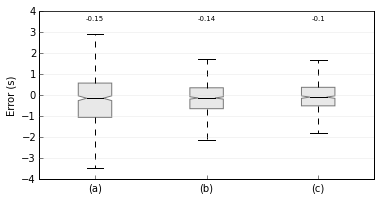

In [23]:
# BOXPLOTS ERRORES DE PREDICCIÓN
errorFeelingBad = feelingBad['$\Delta{}t^{est}$'] - feelingBad['$\Delta{}t^{real}$']
errorMoratFrib = moratFribourg['$\Delta{}t^{est}$'] - moratFribourg['$\Delta{}t^{real}$'] 
errorTest = test['$\Delta{}t^{est}$'] - test['$\Delta{}t^{real}$']
errors = [errorFeelingBad, errorMoratFrib, errorTest]
numBoxes = len(errors)
pos = np.arange(numBoxes)+1

fig = plt.figure(figsize=(6,3), dpi=72)
ax = fig.add_subplot(111)
bp = ax.boxplot(errors, labels=['(a)', '(b)', '(c)'], patch_artist=True, sym='', notch=True)

plt.setp(bp['boxes'], color='black', facecolor = 'lightgrey', alpha=0.5)
plt.setp(bp['medians'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['caps'], color='black')
ax.set_ylim([-4, 4])
top = ax.get_ylim()[1]*0.89
medians = [np.nanmedian(i) for i in errors]
upperLabels = [str(np.round(s, 2)) for s in medians]

for tick,label in zip(range(numBoxes),ax.get_xticklabels()):
    ax.text(pos[tick], top, upperLabels[tick], horizontalalignment='center', size='x-small', color='black')

ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_ylabel('Error (s)')
fig.savefig('../../../Thesis/images/bxplotErrorsCS3.pdf',bbox_inches='tight', dpi=fig.dpi)

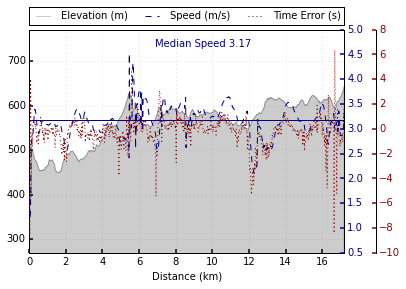

In [84]:
# GRAFICA DEL ERROR DE PREDICCION CON ELEVACION Y VELOCIDAD
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.itervalues():
        sp.set_visible(False)
        
fig, host = plt.subplots(figsize=(7,4), dpi=72)
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

par2.spines["right"].set_position(("axes", 1.1))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)

p1, = host.plot(moratFribourg['Distance'], moratFribourg['Elevation'], color='k', label='Elevation (m)',alpha=0.2)
host.fill_between(moratFribourg['Distance'], 0, moratFribourg['Elevation'], color='k', alpha=0.2)
p2, = par1.plot(moratFribourg['Distance'], moratFribourg['Speed'], color='DarkBlue', linestyle='--', label='Speed (m/s)')
p2.axes.axhline(y=datasets.speed.median(), color='DarkBlue')
p3, = par2.plot(moratFribourg['Distance'], moratFribourg['$\Delta{}t^{est}$'] - moratFribourg['$\Delta{}t^{real}$'], 
                color='DarkRed', linestyle=':', label=r'Time Error (s)')

host.set_xlim([moratFribourg['Distance'].min(), moratFribourg['Distance'].max()])
host.set_xticklabels([np.str(int(i)) for i in host.get_xticks()/1000])
host.set_ylim([moratFribourg['Elevation'].min()*0.6, moratFribourg['Elevation'].max()*1.2])

host.set_xlabel(r'Distance (km)')

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)
host.get_xaxis().tick_bottom()
host.legend((p1, p2, p3),(p1.get_label(), p2.get_label(), p3.get_label()),
           bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.,
            fontsize=10)
host.grid(alpha=0.25)
host.text(0.4*host.get_xlim()[-1],0.95*host.get_ylim()[-1],
          'Median Speed {:.2f}'.format(datasets.speed.median()), color='DarkBlue', fontsize=10)
fig.savefig("../../../Thesis/images/errorCS3MorFrib.pdf", bbox_inches='tight', dpi=fig.dpi)